#Peak Prediction - Washington DC



In [1]:
#import dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/peak_prediction/

/content/drive/MyDrive/peak_prediction


In [3]:
ls

catboost_info/
daily_temperatures_impute_missing.csv
imputed_data.csv
japan.csv
kyoto.csv
liestal.csv
merged_kyoto.csv
merged_kyoto.gsheet
merged_kyoto_off.csv
merged_liestal.csv
merged_liestal.gsheet
merged_liestal_off.csv
merged_vancouver.csv
merged_vancouver.gsheet
merged_vancouver_off.csv
merged_washington_1.csv
merged_washington_co2_test.csv
merged_washington_co2_test_excel.csv
merged_washington_co2_test.gsheet
merged_washington.csv
merged_washington.gsheet
merged_washington_off.csv
merged_washington_test.csv
merged_washington_test_excel.csv
merged_washington_test.gsheet
meteoswiss.csv
README.md
south_korea.csv
USA-NPN_individual_phenometrics_data.csv
USA-NPN_individual_phenometrics_datafield_descriptions.csv
USA-NPN_status_intensity_datafield_descriptions.csv
USA-NPN_status_intensity_observations_data.csv
vancouver.csv
washingtondc.csv


In [4]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE


from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import LabelEncoder
import scipy.integrate as integrate
import xgboost as xgb
from xgboost import plot_tree
!pip install catboost
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00


In [11]:
df = pd.read_csv("merged_vancouver_off.csv")

YEARS = vancouver.year

In [ ]:
# # Load the three datasets
# data1 = pd.read_csv('data1.csv')
# data2 = pd.read_csv('data2.csv')
# test_data = pd.read_csv('test_data.csv')

# # Split the first dataset into training and validation sets
# train1, val1 = train_test_split(washington, test_size=0.2, random_state=42)

# # Train a random forest classifier on the first dataset
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(train1.drop('target', axis=1), train1['target'])

# # Fine-tune the model on the second dataset
# train2, val2 = train_test_split(data2, test_size=0.2, random_state=42)
# clf.fit(train2.drop('target', axis=1), train2['target'])

# 1. EDA

In [12]:
print(df.columns)
print()
# min_date, max_date = df.bloom_doy.min(), df.bloom_doy.max()
print(f'Min bloom date = {min_date} days')
print(f'Max bloom date = {max_date} days')

"""1. Create hashmap: (bloom date class -> bloom date raw)"""
hm_bloom_date = {}
for idx, date in enumerate(range(min_date, max_date, 4)):
    hm_bloom_date[idx] = [date, date+3]
    print(hm_bloom_date[idx])

print(f"\tExample: class 0 is in range {hm_bloom_date[0]} days from Jan 1.")

df.head()

Index(['location', 'year', 'month', 'season', 'tmax_avg', 'tmax_max',
       'tmin_avg', 'tmin_min', 'gdd_avg', 'prcp_avg', 'lat', 'long', 'alt'],
      dtype='object')



AttributeError: ignored

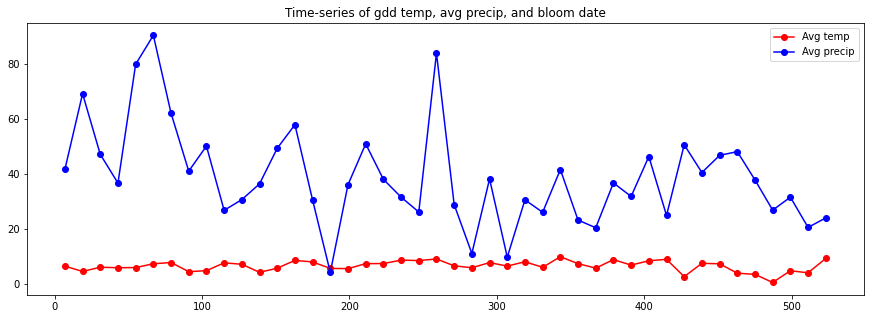

In [14]:
MONTH = 2
plt.figure(figsize=(15,5))
plt.title('Time-series of gdd temp, avg precip, and bloom date')
plt.plot(df[df.month == MONTH].gdd_avg, '-o', color='red', label='Avg temp')
plt.plot(df[df.month == MONTH].prcp_avg, '-o', color='blue', label='Avg precip')
# plt.plot(df[df.month == MONTH].bloom_doy, '-o', color='green', label='GT Bloom date')
plt.legend()

# 2a. Split input & labels
## PLUS: reformat label according to prediction range

In [ ]:
def split_XY(df, input_features, output_features):
    """Preprocess input data"""
    X = df[input_features]
    if 'cat_bloom_doy_last_year' in X:
        X = X.astype({'cat_bloom_doy_last_year': int}, errors = 'ignore')
        
    if 'cat_bloom_doy_last_2_years' in X:
        X = X.astype({'cat_bloom_doy_last_2_years': int}, errors = 'ignore')
        

    """Preprocess labels"""
    Y = df[output_features]

    return X, Y

# ??????
def remove_first_two_years(df, YEARS):
    """Start with years >= year_min + 2 because we shifted cat_bloom_doy column by 2"""
    df = df[df.year >= YEARS.min() + 2]
    try: df = df.dropna().reset_index()
    except: pass
    print(df.year.min())

    return df

"""
    Reformat the label to fit the prediction range (in years)
    E.g: shift(-5) if aims to predict 5 years ahead
"""
def reformat_labels(df, label_name, prediction_range):
    df[label_name] = df[label_name].shift(-12 * prediction_range)
    df = df.dropna().reset_index()
    return df

#Select prediction date here


In [ ]:
"""Split input & labels"""
input_features = ['month', 'tmax_avg', 'tmax_max','tmin_avg', 'tmin_min',
                  'prcp_avg', 'gdd_avg', 'cat_bloom_doy']
output_features = ['bloom_doy'] # OR cat_bloom_doy
PREDICTION_RANGE = 2 #year


washington = remove_first_two_years(washington, YEARS)
original_df = df.copy()
df = reformat_labels(df, label_name=output_features, prediction_range=PREDICTION_RANGE)
display(df.tail(10))
X, Y = split_XY(washington, input_features, output_features)
display(X.head(10))
display(Y.head(10))

# 2b. Split Train & Test set

In [ ]:
def split_train_val_test(df, X, Y, train_months, TRAIN_PERCENT, VAL_PERCENT, TEST_PERCENT):
    assert TRAIN_PERCENT + VAL_PERCENT + TEST_PERCENT == 1.0

    avail_years = df.year.unique()
    total_avail_years = len(avail_years)
    print(f'Total years = {total_avail_years} years')

    
    """Split Train / Val / Test years"""
    train_years = avail_years[: math.ceil(TRAIN_PERCENT*total_avail_years) ]
    val_years = avail_years[math.ceil(TRAIN_PERCENT*total_avail_years) : 
                            -math.ceil((TEST_PERCENT)*total_avail_years)]
    test_years = avail_years[-math.ceil((TEST_PERCENT)*total_avail_years) : ]
    print(f'Train years: {train_years}')
    print(f'Val years: {val_years}')
    print(f'Test years: {test_years}')
    assert len(train_years) + len(val_years) + len(test_years) == len(avail_years)

    """Get (X,Y) for train/val/test sets"""
    train_idx = df[(df.year >= train_years.min()) & (df.year <= train_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index
    val_idx = df[(df.year >= val_years.min()) & (df.year <= val_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index
    test_idx = df[(df.year >= test_years.min()) & (df.year <= test_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index

    X_train, Y_train = X.iloc[train_idx], Y.iloc[train_idx]
    X_val, Y_val = X.iloc[val_idx], Y.iloc[val_idx]
    X_test, Y_test = X.iloc[test_idx], Y.iloc[test_idx]
    assert len(X_train) == len(Y_train) 
    assert len(X_val) == len(Y_val) 
    assert len(X_test) == len(X_test)

    return train_years, X_train, Y_train, val_years, X_val, Y_val, test_years, X_test, Y_test

In [ ]:
"""Train / Val / Test set ratio"""
TRAIN_PERCENT = 0.7
VAL_PERCENT = 0.15
TEST_PERCENT = 0.15
train_months = np.array([0,1,2])

train_years, X_train, Y_train, val_years, X_val, Y_val, test_years, X_test, Y_test = split_train_val_test(df, X, Y, 
                                                                                                          train_months, 
                                                                                                          TRAIN_PERCENT, 
                                                                                                          VAL_PERCENT, 
                                                                                                          TEST_PERCENT)

# 3. Model

In [ ]:
"""3a. Data preparation"""
X_train, X_val, X_test = round(X_train, 3), round(X_val, 3), round(X_test, 3)
X_train.head()

In [ ]:
# cat_features = [0, 7, 8]
# catboost_model = CatBoostRegressor(iterations=200, 
#                                    learning_rate=1, 
#                                    reg_lambda = 40,
#                                    subsample = 0.8,
#                                    random_strength = 20,
#                                    cat_features = cat_features,
#                                    loss_function='RMSE')

# """FIT BASE MODEL"""
# catboost_model.fit(X_train, Y_train, 
#                    use_best_model = True,
#                    eval_set = (X_val, Y_val))

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 400,
                                max_depth = 3,
                                learning_rate = 0.1,
                                reg_lambda = 40,
                                objective = 'reg:squarederror',
                                early_stopping_rounds = 40)
xgb_model.fit(X_train, Y_train, 
              eval_set = [(X_train, Y_train), (X_val, Y_val)],
              verbose = False)

In [ ]:
"""
    Use ensemble of multiple months for prediction
    -> average prediction of each month
"""
print(f'Months used for predictions: {train_months}')
print(f'Prediction range: {PREDICTION_RANGE}')
preds = xgb_model.predict(X_test)
preds = preds.reshape(-1, len(train_months))

preds = preds.mean(axis=-1)
preds = preds.round(0).astype(int)

ground_truths = np.array(Y_test).flatten()
ground_truths = ground_truths.reshape(-1, len(train_months))
ground_truths = ground_truths[:,1].astype(int)

# print("Test years:\n", test_years)
# print("Predictions:\n", preds)
# print("Ground-truth:\n", ground_truths)

rmse = np.sqrt(MSE(ground_truths, preds))
mae = MAE(ground_truths, preds)
print("RMSE : % .2f" %(rmse))
print("MAE : % .2f" %(mae))

print('='*50)
for i in range(len(test_years)):
    print(f'Prediction for {test_years[i]}: {preds[i]}')
    print(f'     Label for {test_years[i]}: {ground_truths[i]}')
    print('='*50)

In [ ]:
"""
    PREDICT 2033? 
    1. TRAIN MODEL WITH 12-YEAR RANGE 
    2. USE THIS MODEL ON 2021 DATA TO PREDICT 2033 (2033 = 2021 + 12)
"""
YEAR_USED = 2021
temp_df = original_df[original_df.year == YEAR_USED]
input_data, _ = split_XY(temp_df, input_features, output_features)
input_data = input_data[ input_data.month.isin(train_months) ]

print(f"Year in use = {YEAR_USED}")
print(f"Prediction Range = {PREDICTION_RANGE}")
print(f'Predicted year = {YEAR_USED + PREDICTION_RANGE}')

preds = xgb_model.predict(input_data)

"""Ensemble predictions from different months"""
preds = preds.reshape(-1, len(train_months))
preds = preds.mean(axis=-1)
preds = preds.round(0).astype(int)[0]
print(f"Predicted bloom date for year {YEAR_USED + PREDICTION_RANGE} = {preds}")

In [ ]:
# cherry = pd.concat([dc,kyoto,liestal])
# cherry.head()

In [ ]:
# n_by_country = cherry.groupby("location")
# n_by_country.head()